### Get Latest log in folder 

In [29]:
import plottinglib.plotting_vr_logs as pl
import os
import cellworld as cw
import numpy as np
import math

### Checking measurements of occlusion spawning location

- all in meters

In [ ]:
# [distance from door, obstacle height on y]
import math
msmts_m = {'1': [20.97, 1.8],
         '3': [21.81, 1.82],
         '4': [23.25, 1.8],
         '5': [13.56, 1.79]
      }

scale = 14.336 
hab_diam = 2.35 # m 
scaled_diam = scale*hab_diam # diam of VR habitat --> meters 
occ_d_edge_true = 6.384 / 100 # from onshape: cm -> m
occ_y_true = 12.700000 / 100 # from onshape: cm -> m 
print(scaled_diam)
occ_y_error = []
d_edge_vr   = []
occ_y_vr    = []

for key, val in msmts_m.items():
    d_edge_vr.append(val[0] / scaled_diam)
    
    # occlusion height (y-axis, edge to edge)
    occ_y_vr.append(val[1] / scaled_diam)
    

    # val.append((val[0]/scaled_diam)+occ_d_edge_true)
    # val.append((val[1]/scaled_diam)) # scaled height of occlusion, should match occ_d_edge 
    # occ_y_error.append((val[3] - occ_y_true)/occ_y_true) 

    # print(val)
print(occ_y_vr)
print(occ_y_true)
# print(f'Occlusion height (y, edge-edge) error: {(sum(occ_y_error)/len(occ_y_error)*100):0.2f}', )

In [30]:
def get_newest_file_in_folder(folder_path:str='../logs', extension="*."):
    import os
    import glob
    if extension == "*":
        search_pattern = os.path.join(folder_path, "*")
    else:
        search_pattern = os.path.join(folder_path, f"*.{extension}")
    files = glob.glob(search_pattern)
    if not files:
        return None
    
    newest_file = max(files, key=os.path.getmtime)
    return newest_file

folder_path = os.path.join('..', 'logs')  # Replace with the path to your folder
extension = "json"  # Replace with the desired file extension (e.g., 'txt', 'jpg', 'py')
newest_file = get_newest_file_in_folder(folder_path, extension)
print(newest_file)

..\logs\lab_03212025_164229.json


### Logs from 3/19/2025 at crown

Showing 3-4 different figures on how hab scale affects trajectory.

In [ ]:
## organize files in a dict (files_dict)
import os
files = [
    ('middle', 'middle_03192025_105907.json', 10.313),
    ('threerotated', 'threescalerotation_03192025_105632.json', 3.400),
    ('three', 'threescale_03192025_105405.json', 3.079),
    ('full', 'default_03192025_094208.json', 14.336)
]

files_dict = {key: {'path': path, 'scale': scale} for key, path, scale in files}
folder_path = os.path.join('..', 'logs')  # Replace with the path to your folder

for key,values in files_dict.items():
    files_dict[key]['path'] = os.path.join(folder_path, files_dict[key]['path'])
    print(files_dict)

### basic plot

In [ ]:
### plot all files from files_dict
import cellworld as cw
import matplotlib.pyplot as plt
import numpy as np
import math
def scale_legacy_y(y):
    return y * 0.5 * math.sqrt(3) + 0.5 - math.sqrt(3) / 4
# Load world and experiment data
for key, value in files_dict.items():
    file  = files_dict[key]['path']
    scale = files_dict[key]['scale']
    print(f'== {files_dict[key]} ({file})')
    
    w = cw.World.get_from_parameters_names('hexagonal',"canonical",'21_05')
    d = cw.Display(w, fig_size=(6,6), padding=0.1, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="black")
    n     = 0
    t_sum = 0
    d.ax.set_title(f'{file} | Scale: {scale} | Diam: {scale*2.35:0.2f} m')
    exp = cw.Experiment.load_from_file(file)

    # Define hexagonal world bounds
    
    for idx in range(len(exp.episodes)):
        episode = exp.episodes[idx]
        preyt = episode.trajectories.get_agent_trajectory('prey')
        if 'default' in file:
            for step in preyt:
                step.location.y = scale_legacy_y(step.location.y)
        predt = episode.trajectories.get_agent_trajectory('predator')
        d.add_trajectories(preyt, colors = {'prey': 'green'}, alphas = {'prey': .7}, zorder = 7)
        # d.add_trajectories(predt, colors = {'predator': 'red'}, alphas = {'predator': .7}, zorder = 7)
        
        # summary info 
        n+=1 
        t_sum += len(preyt) * np.diff(preyt.get('time_stamp')).mean()

    print(f'Total time: {t_sum:.3f} s ({t_sum/60:.3f} min)')
    print(f'Average time per episode: {t_sum / n :.3f} s')

Total time: 35.704 s (0.595 min)
Average time per episode: 17.852 s


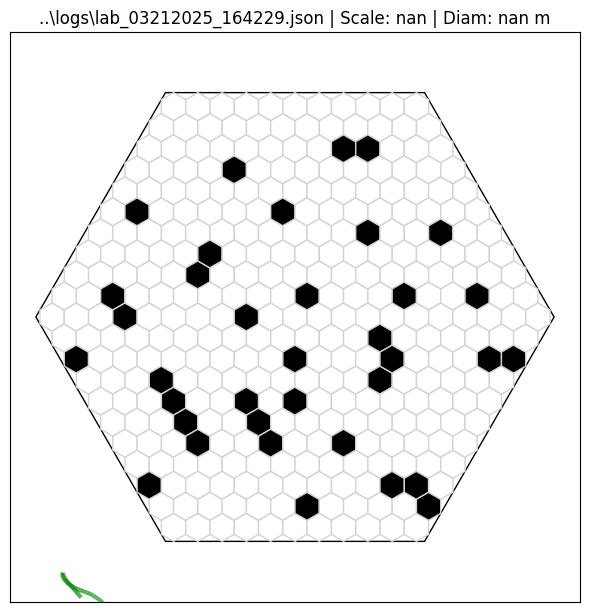

In [32]:
basic_plot(newest_file)


### Plotting

In [ ]:
## show summary info of trajectories 
# show time steps 

def detect_outliers(array):
    import numpy as np 
    mean = np.mean(array)
    std = np.std(array)
    lower_bound = mean - std
    upper_bound = mean + std
    outliers = array[(array < lower_bound) | (array > upper_bound)]
    
    if len(outliers) > 0:
        return f"Outliers detected: {outliers}"
    else:
        return "No outliers detected"
    
def show_info(filepath:str=None):
    import numpy as np
    if not filepath: print("need a filepath"); return

    e = Experiment.load_from_file(filepath)
    if e is None: 
        print("No experiment found: e is NONE")
        return 
    
    w = World.get_from_parameters_names('hexagonal',"canonical",e.occlusions)
    subject_str = 'prey'
    scalar = 1.0
    mv = 1.0
    print(f'Episode count: {len(e.episodes)}')
    grads = []
    for i, episode in enumerate(e.episodes[:]):
        t = episode.trajectories
        tprey = t.get_agent_trajectory('prey')
        tpred = t.get_agent_trajectory('predator')
        
        frame_list = tprey.get('frame')
        nv = [f/(max(frame_list)) for f in frame_list]
        grad = np.gradient(nv)
        grads.append(grad)

    return grads
    
g = show_info(file)

In [33]:
def basic_plot(file=None, scale:float=np.nan):
    w = cw.World.get_from_parameters_names('hexagonal',"canonical",'21_05')
    d = cw.Display(w, fig_size=(6,6), padding=0.1, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="black")
    n     = 0
    t_sum = 0
    d.ax.set_title(f'{file} | Scale: {scale} | Diam: {scale*2.35:0.2f} m')
    exp = cw.Experiment.load_from_file(file)
    
    for idx in range(len(exp.episodes)):
        episode = exp.episodes[idx]
        preyt = episode.trajectories.get_agent_trajectory('prey')
        for step in preyt:
            step.location.y = (step.location.y - 0.5)*2/(math.sqrt(3))
            step.location.x = (step.location.x)
            pass
        d.add_trajectories(preyt, colors = {'prey': 'green'}, alphas = {'prey': .7}, zorder = 7)
        # d.add_trajectories(predt, colors = {'predator': 'red'}, alphas = {'predator': .7}, zorder = 7)
        # summary info 
        n+=1 
        t_sum += len(preyt) * np.diff(preyt.get('time_stamp')).mean()

    print(f'Total time: {t_sum:.3f} s ({t_sum/60:.3f} min)')
    print(f'Average time per episode: {t_sum / n :.3f} s')

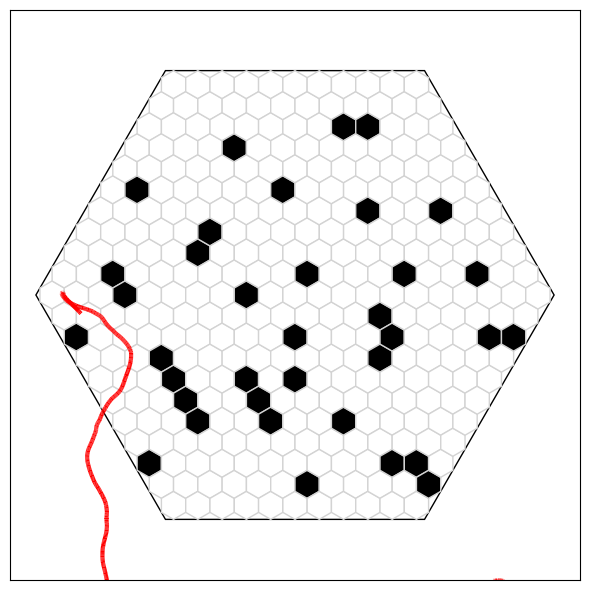

In [34]:
w = cw.World.get_from_parameters_names('hexagonal',"canonical",'21_05')
d = cw.Display(w, fig_size=(6,6), padding=0.1, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="black")
import matplotlib.pyplot as plt
n     = 0
t_sum = 0
file = get_newest_file_in_folder(extension='json')
# file = os.path.join('../logs','walk_03212025_110628.json')
scale = 2.515
exp = cw.Experiment.load_from_file(file)
# plt.figure(figsize=(4, 4))

c = 0
for episode in exp.episodes: 
    preyt = episode.trajectories.get_agent_trajectory('prey')
    locations = preyt.get_locations()['prey']
    d.add_trajectories(preyt,colors={'prey':'red'})
    # plt.plot(x, y, marker='o', linestyle='-', label=f"episode {c}")
    # print(f'[min/max] x: {min(x):0.2f}/{max(x):0.2f} | y:{min(y):0.2f}/{max(y):0.2f}')
    # basic_plot(file=file,scale=0.9)
    plt.xlabel("X Coordinate")
    c+=1 
# plt.xlim([-1,1])
# plt.ylim([-1,1])
# plt.ylabel("Y Coordinate")
# plt.title("Prey Trajectory")
# plt.legend()
# plt.grid(True)
# plt.show()

### NxN Landmark spawning

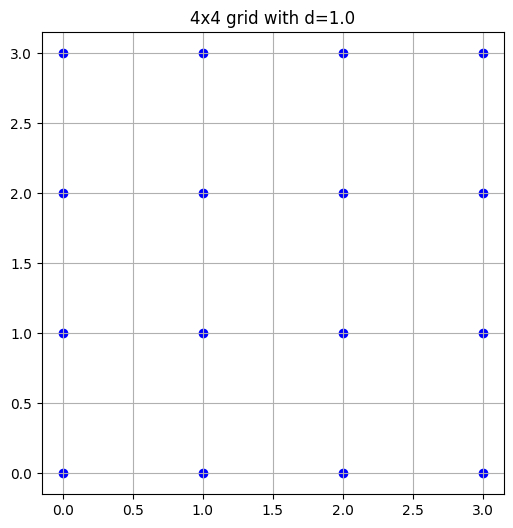

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 4      # grid size (NxN)
d = 1.0     # spacing between points

# Generate grid of points
x_vals = np.arange(N) * d
y_vals = np.arange(N) * d
xx, yy = np.meshgrid(x_vals, y_vals)
points = np.vstack([xx.ravel(), yy.ravel()]).T

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], color='blue')
plt.gca().set_aspect('equal')
plt.title(f'{N}x{N} grid with d={d}')
plt.grid(True)
plt.show()
